###Load Data

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os, shutil
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!gdown --id '16k0608XLsNcCWvX9mawqv_ojAHQB7aa9'
#!unzip -q OneDrive-2021-12-12.zip
#https://drive.google.com/drive/folders/1KGXp-WE5SJ1xQqU9EQWsXNVA17XWS84w?usp=sharing
#https://drive.google.com/u/0/uc?id=17BZWzb-FTx00cJAIrTHKogXdaZVuUtiM&export=download
#https://drive.google.com/u/0/uc?export=download&confirm=dlti&id=17BZWzb-FTx00cJAIrTHKogXdaZVuUtiM
#https://drive.google.com/file/d/1l8YzfPxHeMuLfUdSILbbb7gK98d3a9Ja/view?usp=sharing
#!gdown --id '1l8YzfPxHeMuLfUdSILbbb7gK98d3a9Ja'
!unzip -q /content/drive/MyDrive/split_.zip

In [ ]:
# check
path, dirs, files = next(os.walk("content/drive/MyDrive/split/train/negative"))
print("train neg ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/train/positive"))
print("train pos ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/test/negative"))
print("test neg ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/test/positive"))
print("test pos ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/val/negative"))
print("val neg ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/val/positive"))
print("val pos ",len(files))

train neg  2484
train pos  2484
test neg  359
test pos  45
val neg  363
val pos  44


### Transform to tensor

In [ ]:
# raw img size 4040 * 5416 pixel
wid = 1000
hgt = 1000

train_tfm = transforms.Compose([
    transforms.Resize((1000, 1000)),
    # transforms.ColorJitter(contrast=1),
    # transforms.RandomRotation(degrees = 8, fill = 1),
    # transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((1000, 1000)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# input[512, 1, 28, 28]

### Build Dataset

In [ ]:
batch_size = 16
#train_set = datasets.DatasetFolder("split/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
subtrain_set = datasets.DatasetFolder("content/drive/MyDrive/split/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = datasets.DatasetFolder("content/drive/MyDrive/split/val", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = datasets.DatasetFolder("content/drive/MyDrive/split/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # , num_workers=8, pin_memory=True
subtrain_loader = DataLoader(subtrain_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
print("Get length:", len(subtrain_set))
print("Get training data at position 3: ", subtrain_set[3])

Get length: 4968
Get training data at position 3:  (tensor([[[0.8157, 0.8039, 0.7922,  ..., 0.1137, 0.1137, 0.1137],
         [0.7961, 0.7882, 0.7804,  ..., 0.1098, 0.1098, 0.1059],
         [0.7725, 0.7765, 0.7765,  ..., 0.1098, 0.1020, 0.0980],
         ...,
         [0.4039, 0.4039, 0.4039,  ..., 0.2471, 0.2627, 0.2706],
         [0.4078, 0.4039, 0.4039,  ..., 0.2471, 0.2627, 0.2706],
         [0.4157, 0.4118, 0.4078,  ..., 0.2471, 0.2588, 0.2667]],

        [[0.8157, 0.8039, 0.7922,  ..., 0.1137, 0.1137, 0.1137],
         [0.7961, 0.7882, 0.7804,  ..., 0.1098, 0.1098, 0.1059],
         [0.7725, 0.7765, 0.7765,  ..., 0.1098, 0.1020, 0.0980],
         ...,
         [0.4039, 0.4039, 0.4039,  ..., 0.2471, 0.2627, 0.2706],
         [0.4078, 0.4039, 0.4039,  ..., 0.2471, 0.2627, 0.2706],
         [0.4157, 0.4118, 0.4078,  ..., 0.2471, 0.2588, 0.2667]],

        [[0.8157, 0.8039, 0.7922,  ..., 0.1137, 0.1137, 0.1137],
         [0.7961, 0.7882, 0.7804,  ..., 0.1098, 0.1098, 0.1059],
      

In [ ]:
subtrain_set[0][0].shape

torch.Size([3, 1000, 1000])

### MLP (博任)

In [ ]:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)
#CUDA_LAUNCH_BLOCKING=1
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
#get number of input features
#D_in = 3*5416*4040
D_in = 1000*1000
H = 56
#Binary classification problem
D_out = 1
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Running on device: ", device)
'''
net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)
'''
class model(nn.Module): # 2 types: real, fake
    def __init__(self, backbone): # positive parameter means grl or not, True: not grl
        super(model, self).__init__()
        # self.convert = nn.Conv2d(1, 3, 2)
        self.backbone = backbone
        self.classifier = nn.Sequential(
            nn.Linear(1000, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # print('ori = ', x.shape)
        # x = self.convert(x)
        # print(x.shape)
        x = self.backbone(x)
      
        x = self.classifier(x)

        return x

#backbone = torchvision.models.resnet18(pretrained=True)
backbone = torchvision.models.resnet34(pretrained=True)
#下面這個model更猛，但你可能跑不動
#backbone = torchvision.models.resnext101_32x8d(pretrained=True)

my_model = model(backbone)

# move the model to device (i.e., cpu or gpu)
my_model = my_model.to(device)

Running on device:  cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# define the optimizer
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.0001)
# Binary Cross Entropy Loss
loss_fn = torch.nn.BCELoss()
#loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
nepoch = 100
step_count = 0
log_interval = 10
#trainingAccuracy_list = []
#validationAccuracy_list = []
trainingloss_list = []
validloss_list = []
validloss_weighted_list = []
step_count_list = []
#train_ncorrect = 0
#train_test_nobs = 0
cumulative_loss = 0
countdown = 100


for epoch_id in range(0, nepoch):    
    if countdown == 0:
        print("early stop2")
        break  
    for batch_idx, (inputs, targets) in enumerate(subtrain_loader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))
        step_count += 1        
        my_model.train()
        #print(inputs)
        #print(targets)
        inputs, targets = inputs.to(device), targets.to(device)
      
        optimizer.zero_grad()
        outputs = my_model(inputs)   
        targets = targets.float()
        loss = loss_fn(outputs, targets)
        cumulative_loss += loss

        #train_pred = (outputs.cpu().detach().numpy() > 0.5).astype('float32')
        #train_tmp_correct = (train_pred == targets.cpu().detach().numpy()).sum()
        #train_ncorrect += train_tmp_correct
        #train_test_nobs += len(train_pred) 
  
        loss.backward()
        optimizer.step()
        #if step_count % log_interval == 0: 
        if step_count % log_interval == 0:
            step_count_list.append(step_count)
            #trainingAccuracy = train_ncorrect / train_test_nobs
            #valid_ncorrect = 0
            #valid_test_nobs = 0
            validoutputs_list = []
            validtargets_list = []
            with torch.no_grad():
              for i, (validinputs, validtargets) in enumerate(valid_loader):
                if i == 0:
                  print("Calculating Loss...")
                my_model.eval()
                validtargets = validtargets.reshape((-1, 1))
                validinputs, validtargets = validinputs.to(device), validtargets.to(device)
                validoutputs = my_model(validinputs) 
                validtargets = validtargets.float()
                validoutputs_list.append(validoutputs)
                validtargets_list.append(validtargets)
                #valid_pred = (validoutputs.cpu().detach().numpy() > 0.5).astype('float32')
                #valid_tmp_correct = (valid_pred == validtargets.cpu().detach().numpy()).sum()
                #valid_ncorrect += valid_tmp_correct
                #valid_test_nobs += len(valid_pred) 
            #validationAccuracy = valid_ncorrect / valid_test_nobs
            validoutputs_array = np.array(validoutputs_list)
            for i in range(len(validoutputs_array)):
              validoutputs_array[i] = validoutputs_array[i].to("cpu")
              validoutputs_array[i] = validoutputs_array[i].numpy()
            full_valid_outputs = np.concatenate(validoutputs_array, axis=0 )
            validtargets_array = np.array(validtargets_list)
            for i in range(len(validtargets_array)):
              validtargets_array[i] = validtargets_array[i].to("cpu")
              validtargets_array[i] = validtargets_array[i].numpy()
            full_valid_targets = np.concatenate(validtargets_array, axis=0 )
            validloss = loss_fn(torch.tensor(full_valid_outputs), torch.tensor(full_valid_targets))
            trainingloss = cumulative_loss / step_count
            weighted_loss = nn.BCELoss(reduction='none') 
            weight = torch.zeros_like(torch.tensor(full_valid_targets))
            weight = torch.fill_(weight, 1)
            weight[torch.tensor(full_valid_targets) == 1] = 10
            weighted_loss = weighted_loss(torch.tensor(full_valid_outputs), torch.tensor(full_valid_targets))
            weighted_loss = torch.mean(weighted_loss * weight)  
            validloss_weighted = weighted_loss
            #trainingAccuracy_list.append(trainingAccuracy)
            #validationAccuracy_list.append(validationAccuracy)
            trainingloss_list.append(trainingloss.item())
            validloss_list.append(validloss.item())
            validloss_weighted_list.append(validloss_weighted.item())
            print("Epoch %d Batch %d: trainingLoss = %.3f, validationLoss = %.3f, Weighted validationLoss = %.3f  (minibatch size = %d)" % (epoch_id, step_count, trainingloss.item(), validloss.item(), validloss_weighted.item(), len(targets)))
            #print("Epoch %d Batch %d: trainingAccuracy = %.3f, validationAccuracy = %.3f (minibatch size = %d)" % (epoch_id, step_count, trainingAccuracy, validationAccuracy, len(targets)))        
            if step_count < 20:
                before_lowestloss = validloss_weighted
                PATH = './resnet34_weightedloss.pth' #save model
                torch.save(my_model.state_dict(), PATH)
                !cp resnet34_weightedloss.pth "drive/My Drive"
            elif step_count >=20:
                if validloss_weighted < before_lowestloss:
                    print("Oh yah") #爽啦，進步了！
                    PATH = './resnet34_weightedloss.pth' #save model
                    torch.save(my_model.state_dict(), PATH)
                    !cp resnet34_weightedloss.pth "drive/My Drive"
                    before_lowestloss = validloss_weighted
                    countdown = 100 #經過1000個batch相當於經過100個10個batch
                else:
                    countdown -= 1
            if countdown == 0:
                print("early stop1") #好了啦
                break

Calculating Loss...
Epoch 0 Batch 10: trainingLoss = 0.607, validationLoss = 0.450, Weighted validationLoss = 1.895  (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 20: trainingLoss = 0.576, validationLoss = 0.997, Weighted validationLoss = 1.377  (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 30: trainingLoss = 0.590, validationLoss = 1.001, Weighted validationLoss = 1.597  (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 40: trainingLoss = 0.587, validationLoss = 0.472, Weighted validationLoss = 2.831  (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 50: trainingLoss = 0.589, validationLoss = 0.966, Weighted validationLoss = 1.312  (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 60: trainingLoss = 0.593, validationLoss = 0.711, Weighted validationLoss = 1.250  (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 70: trainingLoss = 0.587, validationLoss = 0.876, Weighted validationLoss = 1.449  (minibatch size = 16)
Calcul

In [ ]:
my_model.load_state_dict(torch.load(PATH)) #use the saved model to test

<All keys matched successfully>

In [ ]:
my_model.eval()
print("Doing model testing...")
test_nobs = 0
ncorrect = 0
pred_list = []
true_list = []
outputs_list = []
targets_list = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):            
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape((-1, 1))
        outputs = my_model(inputs)
        targets = targets.float()
        outputs_list.append(outputs)
        targets_list.append(targets)              
        pred = (outputs.cpu().numpy() > 0.5).astype('float32')
        pred_list.extend(pred.flatten().tolist())
        true_list.extend(targets.flatten().tolist())
        tmp_correct = (pred == targets.cpu().numpy()).sum()
        ncorrect += tmp_correct
        test_nobs += len(pred)        
accuracy = ncorrect / test_nobs
#print(np.array(outputs_list))
#print(np.array(outputs_list).shape)
#print(np.array(targets_list))
#print(np.array(targets_list).shape)
outputs_array = np.array(outputs_list)
for i in range(len(outputs_array)):
  outputs_array[i] = outputs_array[i].to("cpu")
  outputs_array[i] = outputs_array[i].numpy()
full_test_outputs = np.concatenate(outputs_array, axis=0 )
targets_array = np.array(targets_list)
for i in range(len(targets_array)):
  targets_array[i] = targets_array[i].to("cpu")
  targets_array[i] = targets_array[i].numpy()
full_test_targets = np.concatenate(targets_array, axis=0 )
testloss = loss_fn(torch.tensor(full_test_outputs), torch.tensor(full_test_targets))
print("Test loss = %.3f" % testloss.item())
print("Accuracy = %.3f" % accuracy)


Doing model testing...
Test loss = 0.747
Accuracy = 0.582


In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
print(metrics.classification_report(true_list, pred_list))
print("AUC:",roc_auc_score(true_list, pred_list))

              precision    recall  f1-score   support

         0.0       0.92      0.58      0.71       359
         1.0       0.15      0.60      0.24        45

    accuracy                           0.58       404
   macro avg       0.54      0.59      0.48       404
weighted avg       0.83      0.58      0.66       404

AUC: 0.5896935933147632


In [ ]:
!cp resnet34_weightedloss.pth "drive/My Drive"

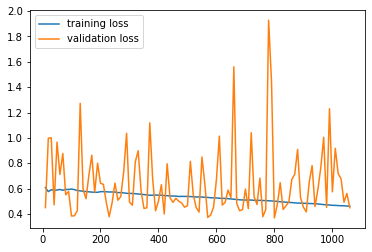

In [ ]:
import matplotlib.pyplot as plt
plt.plot(step_count_list, trainingloss_list, label = "training loss")
plt.plot(step_count_list, validloss_list, label = "validation loss")
plt.legend()
plt.show()

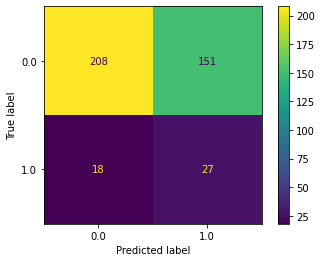

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_list, pred_list)

plt.show()
